In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

In [32]:
# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [33]:
# English vocabulary (source)
SRC_VOCAB = {
    '<pad>': 0, '<sos>': 1, '<eos>': 2,
    'hello': 3, 'goodbye': 4, 'thanks': 5, 'thank': 6, 'you': 7,
    'good': 8, 'morning': 9, 'afternoon': 10, 'evening': 11, 'night': 12,
    'please': 13, 'welcome': 14, 'how': 15, 'are': 16, 'is': 17, 'the': 18,
    'where': 19, 'what': 20, 'when': 21, 'time': 22, 'restaurant': 23,
    'water': 24, 'food': 25, 'delicious': 26, 'expensive': 27, 'cheap': 28,
    'can': 29, 'i': 30, 'have': 31, 'help': 32, 'me': 33, 'today': 34,
    'tomorrow': 35, 'yesterday': 36, 'name': 37, 'my': 38, 'your': 39,
    'friend': 40, 'family': 41, 'menu': 42, 'check': 43, 'bill': 44,
    'and': 45
}

# Spanish vocabulary (target)
TRG_VOCAB = {
    '<pad>': 0, '<sos>': 1, '<eos>': 2,
    'hola': 3, 'adios': 4, 'gracias': 5, 'por': 6, 'favor': 7,
    'tu': 8, 'usted': 9, 'como': 10, 'estas': 11, 'buenos': 12, 'dias': 13,
    'buenas': 14, 'tardes': 15, 'noches': 16, 'bienvenido': 17, 'bienvenida': 18,
    'donde': 19, 'esta': 20, 'el': 21, 'la': 22, 'restaurante': 23,
    'agua': 24, 'comida': 25, 'deliciosa': 26, 'delicioso': 27, 'caro': 28,
    'cara': 29, 'barato': 30, 'barata': 31, 'puedo': 32, 'yo': 33, 'tener': 34,
    'ayuda': 35, 'ayudame': 36, 'hoy': 37, 'mañana': 38, 'ayer': 39,
    'nombre': 40, 'mi': 41, 'su': 42, 'amigo': 43, 'amiga': 44, 'familia': 45,
    'menu': 46, 'cuenta': 47, 'factura': 48, 'cual': 49, 'es': 50, 'puedes': 51,
    'que': 52, 'y': 53, 'bueno': 54
}

# Create reverse mappings
SRC_IDX2WORD = {v: k for k, v in SRC_VOCAB.items()}
TRG_IDX2WORD = {v: k for k, v in TRG_VOCAB.items()}

# Training data pairs (English -> Spanish)
TRAIN_DATA = [
    (['hello', 'how', 'are', 'you'], ['hola', 'como', 'estas', 'tu']),
    (['good', 'morning'], ['buenos', 'dias']),
    (['good', 'afternoon'], ['buenas', 'tardes']),
    (['good', 'evening'], ['buenas', 'tardes']),
    (['good', 'night'], ['buenas', 'noches']),
    (['thank', 'you'], ['gracias']),
    (['thanks'], ['gracias']),
    (['please'], ['por', 'favor']),
    (['welcome'], ['bienvenido']),
    (['goodbye'], ['adios']),
    (['where', 'is', 'the', 'restaurant'], ['donde', 'esta', 'el', 'restaurante']),
    (['can', 'i', 'have', 'water', 'please'], ['puedo', 'tener', 'agua', 'por', 'favor']),
    (['the', 'food', 'is', 'delicious'], ['la', 'comida', 'esta', 'deliciosa']),
    (['what', 'is', 'your', 'name'], ['cual', 'es', 'su', 'nombre']),
    (['my', 'name', 'is'], ['mi', 'nombre', 'es']),
    (['today', 'is', 'good'], ['hoy', 'es', 'bueno']),
    (['can', 'you', 'help', 'me', 'please'], ['puedes', 'ayudame', 'por', 'favor']),
    (['the', 'check', 'please'], ['la', 'cuenta', 'por', 'favor']),
    (['how', 'expensive', 'is', 'the', 'menu'], ['que', 'caro', 'es', 'el', 'menu']),
    (['my', 'friend', 'and', 'family'], ['mi', 'amigo', 'y', 'familia'])
]

In [34]:
# Prepare data with <sos> and <eos> tokens
def prepare_data(data):
    src_prepared = []
    trg_prepared = []

    for src_sent, trg_sent in data:
        # Convert words to indices
        src_indices = [SRC_VOCAB[word] for word in src_sent]
        trg_indices = [TRG_VOCAB[word] for word in trg_sent]

        # Add <sos> and <eos> tokens
        src_indices = [SRC_VOCAB['<sos>']] + src_indices + [SRC_VOCAB['<eos>']]
        trg_indices = [TRG_VOCAB['<sos>']] + trg_indices + [TRG_VOCAB['<eos>']]

        src_prepared.append(src_indices)
        trg_prepared.append(trg_indices)

    return src_prepared, trg_prepared

In [35]:
# Pad sequences to same length
def pad_sequences(sequences, pad_idx):
    max_len = max(len(seq) for seq in sequences)
    padded_seqs = [seq + [pad_idx] * (max_len - len(seq)) for seq in sequences]
    return torch.tensor(padded_seqs, dtype=torch.long)

In [36]:
# Prepare the data
src_data, trg_data = prepare_data(TRAIN_DATA)
src_padded = pad_sequences(src_data, SRC_VOCAB['<pad>'])
trg_padded = pad_sequences(trg_data, TRG_VOCAB['<pad>'])

# Create dataset
dataset = torch.utils.data.TensorDataset(src_padded, trg_padded)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

In [37]:
# 1. Seq2Seq without Attention
class EncoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout=0.5):
        super(EncoderLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src shape: [batch_size, seq_len]
        embedded = self.dropout(self.embedding(src))
        # embedded shape: [batch_size, seq_len, embedding_dim]

        outputs, (hidden, cell) = self.lstm(embedded)
        # outputs shape: [batch_size, seq_len, hidden_dim]
        # hidden shape: [1, batch_size, hidden_dim]
        # cell shape: [1, batch_size, hidden_dim]

        return outputs, (hidden, cell)

class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout=0.5):
        super(DecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, hidden_cell):
        # trg shape: [batch_size, 1]
        # hidden_cell is a tuple (hidden, cell)
        embedded = self.dropout(self.embedding(trg))
        # embedded shape: [batch_size, 1, embedding_dim]

        output, (hidden, cell) = self.lstm(embedded, hidden_cell)
        # output shape: [batch_size, 1, hidden_dim]
        # hidden shape: [1, batch_size, hidden_dim]
        # cell shape: [1, batch_size, hidden_dim]

        prediction = self.fc_out(output.squeeze(1))
        # prediction shape: [batch_size, vocab_size]

        return prediction, (hidden, cell)

class Seq2SeqNoAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqNoAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src shape: [batch_size, src_len]
        # trg shape: [batch_size, trg_len]

        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len - 1, trg_vocab_size).to(self.device)

        # Encode the source sequence
        _, (hidden, cell) = self.encoder(src)

        # First token is <sos>
        input = trg[:, 0:1]

        for t in range(1, trg_len):
            # Use previous hidden state to generate next token
            output, (hidden, cell) = self.decoder(input, (hidden, cell))

            # Store prediction
            outputs[:, t-1] = output

            # Teacher forcing: use real target as next input with probability teacher_forcing_ratio
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the highest predicted token
            top1 = output.argmax(1)

            # Use either target token or predicted token as next input
            input = trg[:, t:t+1] if teacher_force else top1.unsqueeze(1)

        return outputs

In [ ]:
# 2. Seq2Seq with Attention
class AttentionDecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout=0.5):
        super(AttentionDecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim + hidden_dim, hidden_dim, batch_first=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, hidden_cell, encoder_outputs):
        # trg shape: [batch_size, 1]
        # hidden_cell is a tuple (hidden, cell)
        # hidden shape: [1, batch_size, hidden_dim]
        # cell shape: [1, batch_size, hidden_dim]
        # encoder_outputs shape: [batch_size, src_len, hidden_dim]

        hidden, cell = hidden_cell
        batch_size = trg.shape[0]
        src_len = encoder_outputs.shape[1]

        embedded = self.dropout(self.embedding(trg))
        # embedded shape: [batch_size, 1, embedding_dim]

        # Calculate attention scores
        # Repeat hidden state across src_len
        hidden_repeated = hidden.transpose(0, 1).repeat(1, src_len, 1)
        # hidden_repeated shape: [batch_size, src_len, hidden_dim]

        # Concatenate encoder outputs and hidden state
        attn_input = torch.cat((encoder_outputs, hidden_repeated), dim=2)
        # attn_input shape: [batch_size, src_len, hidden_dim*2]

        # Calculate attention scores
        attn_scores = self.attention(attn_input)
        # attn_scores shape: [batch_size, src_len, 1]

        # Apply softmax to get attention weights
        attn_weights = F.softmax(attn_scores, dim=1)
        # attn_weights shape: [batch_size, src_len, 1]

        # Calculate context vector
        context = torch.bmm(encoder_outputs.transpose(1, 2), attn_weights)
        # context shape: [batch_size, hidden_dim, 1]
        context = context.transpose(1, 2)
        # context shape: [batch_size, 1, hidden_dim]

        # Concatenate embedded and context
        lstm_input = torch.cat((embedded, context), dim=2)
        # lstm_input shape: [batch_size, 1, embedding_dim + hidden_dim]

        # Feed through LSTM
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        # output shape: [batch_size, 1, hidden_dim]

        # Make prediction
        prediction = self.fc_out(output.squeeze(1))
        # prediction shape: [batch_size, vocab_size]

        return prediction, (hidden, cell), attn_weights

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src shape: [batch_size, src_len]
        # trg shape: [batch_size, trg_len]

        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len - 1, trg_vocab_size).to(self.device)

        # Encode the source sequence
        encoder_outputs, (hidden, cell) = self.encoder(src)

        # First token is <sos>
        input = trg[:, 0:1]

        for t in range(1, trg_len):
            # Use previous hidden state, encoder outputs to generate next token (with attention)
            output, (hidden, cell), _ = self.decoder(input, (hidden, cell), encoder_outputs)

            # Store prediction
            outputs[:, t-1] = output

            # Teacher forcing: use real target as next input with probability teacher_forcing_ratio
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the highest predicted token
            top1 = output.argmax(1)

            # Use either target token or predicted token as next input
            input = trg[:, t:t+1] if teacher_force else top1.unsqueeze(1)

        return outputs

In [ ]:
# Training function
def train(model, dataloader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for src, trg in dataloader:
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        # Forward pass
        output = model(src, trg)

        # Reshape output and target for loss calculation
        output_dim = output.shape[-1]
        output = output.view(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        # Calculate loss
        loss = criterion(output, trg)

        # Backpropagation
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Update parameters
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [ ]:
# Function to translate a sentence
def translate_sentence(model, sentence, src_vocab, trg_vocab, device, max_len=10, attention=False):
    model.eval()

    # Convert sentence to indices
    if isinstance(sentence, str):
        sentence = sentence.lower().split()

    src_indices = [src_vocab['<sos>']] + [src_vocab.get(word, src_vocab['<eos>']) for word in sentence] + [src_vocab['<eos>']]
    src_tensor = torch.tensor([src_indices]).to(device)

    # Encode the source sentence
    if attention:
        encoder_outputs, (hidden, cell) = model.encoder(src_tensor)
    else:
        _, (hidden, cell) = model.encoder(src_tensor)

    # Start with <sos> token
    trg_indices = [trg_vocab['<sos>']]

    for i in range(max_len):
        trg_tensor = torch.tensor([trg_indices[-1]]).unsqueeze(0).to(device)

        # Decode
        if attention:
            output, (hidden, cell), _ = model.decoder(trg_tensor, (hidden, cell), encoder_outputs)
        else:
            output, (hidden, cell) = model.decoder(trg_tensor, (hidden, cell))

        # Get the most likely word
        pred_token = output.argmax(1).item()

        # Add to translation
        trg_indices.append(pred_token)

        # If <eos> token, stop translating
        if pred_token == trg_vocab['<eos>']:
            break

    # Convert indices to words
    trg_idx2word = {v: k for k, v in trg_vocab.items()}
    translation = [trg_idx2word[idx] for idx in trg_indices if idx not in [trg_vocab['<sos>'], trg_vocab['<eos>']]]

    return translation

In [ ]:
# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model parameters
INPUT_DIM = len(SRC_VOCAB)
OUTPUT_DIM = len(TRG_VOCAB)
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
LEARNING_RATE = 0.001
CLIP = 1.0
N_EPOCHS = 50

# Initialize models
# 1. Without Attention
encoder_no_attn = EncoderLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM)
decoder_no_attn = DecoderLSTM(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM)
model_no_attn = Seq2SeqNoAttention(encoder_no_attn, decoder_no_attn, device).to(device)

# 2. With Attention
encoder_attn = EncoderLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM)
decoder_attn = AttentionDecoderLSTM(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM)
model_attn = Seq2SeqWithAttention(encoder_attn, decoder_attn, device).to(device)

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss(ignore_index=TRG_VOCAB['<pad>'])
optimizer_no_attn = optim.Adam(model_no_attn.parameters(), lr=LEARNING_RATE)
optimizer_attn = optim.Adam(model_attn.parameters(), lr=LEARNING_RATE)

In [ ]:
no_attn_losses = []
attn_losses = []

for epoch in range(N_EPOCHS):
    # Train without attention
    loss_no_attn = train(model_no_attn, dataloader, optimizer_no_attn, criterion, CLIP)
    no_attn_losses.append(loss_no_attn)

    # Train with attention
    loss_attn = train(model_attn, dataloader, optimizer_attn, criterion, CLIP)
    attn_losses.append(loss_attn)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1}')
        print(f'No Attention Loss: {loss_no_attn:.4f}')
        print(f'With Attention Loss: {loss_attn:.4f}')

Epoch: 10
No Attention Loss: 1.7752
With Attention Loss: 1.4787
Epoch: 20
No Attention Loss: 0.3909
With Attention Loss: 0.3690
Epoch: 30
No Attention Loss: 0.0935
With Attention Loss: 0.0810
Epoch: 40
No Attention Loss: 0.0205
With Attention Loss: 0.0203
Epoch: 50
No Attention Loss: 0.0094
With Attention Loss: 0.0089


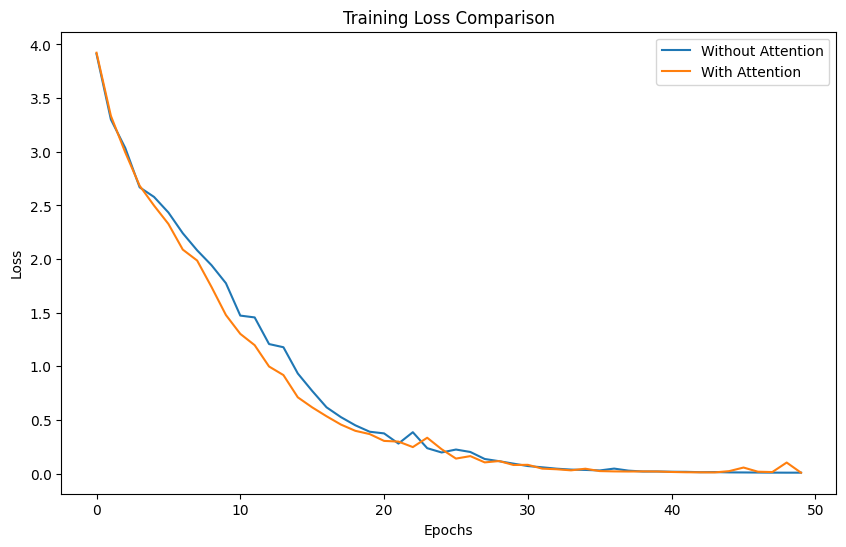

In [ ]:
  # Plot training losses
  plt.figure(figsize=(10, 6))
  plt.plot(no_attn_losses, label='Without Attention')
  plt.plot(attn_losses, label='With Attention')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training Loss Comparison')
  plt.legend()
  plt.show()

In [ ]:
# Test with some examples
test_sentences = [
    "hello how are you",
    "good morning",
    "thank you",
    "where is the restaurant",
    "the food is delicious"
]

# Translate using model without attention
for test_sentence in test_sentences:
    translation_no_attn = translate_sentence(model_no_attn, test_sentence, SRC_VOCAB, TRG_VOCAB, device, attention=False)
    print(f'Original: {test_sentence}')
    print(f'No Attention Translation: {translation_no_attn}')

    # Translate using model with attention
    translation_attn = translate_sentence(model_attn, test_sentence, SRC_VOCAB, TRG_VOCAB, device, attention=True)
    print(f'With Attention Translation: {translation_attn}')

Original: hello how are you
No Attention Translation: ['hola', 'como', 'estas', 'tu']
With Attention Translation: ['hola', 'como', 'estas', 'tu']
Original: good morning
No Attention Translation: ['puedo', 'tener', 'agua', 'por', 'favor']
With Attention Translation: ['buenos', 'dias']
Original: thank you
No Attention Translation: ['hola', 'como', 'estas', 'tu']
With Attention Translation: ['hola', 'como', 'estas', 'tu']
Original: where is the restaurant
No Attention Translation: ['donde', 'esta', 'el', 'restaurante']
With Attention Translation: ['donde', 'esta', 'el', 'restaurante']
Original: the food is delicious
No Attention Translation: ['la', 'comida', 'esta', 'deliciosa']
With Attention Translation: ['la', 'comida', 'esta', 'deliciosa']
